<a href="https://colab.research.google.com/github/rachit-shah/adbi-project/blob/master/HAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data and Glove Model From Drive

In [52]:
# Mounting google drive to access data and glove model
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
#import all required packages and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import nltk
nltk.download('popular')

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, SpatialDropout1D, TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Model
from keras.initializers import Constant

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.layers import Embedding

import time
from keras.models import model_from_json

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [0]:
# copying dataset and embedding from drive. Unpacking the compressed files
!cp gdrive/'My Drive'/bbc-fulltext.zip .
!cp gdrive/'My Drive'/glove.6B.zip .
!unzip bbc-fulltext.zip > out.txt
!rm bbc/README.TXT
!unzip glove.6B.zip

^C
replace bbc/business/001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

KeyboardInterrupt: ignored

In [0]:
# from https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 123

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)


# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


In [0]:
#Read Data
categories = ['business','entertainment','politics','sport','tech']
df = pd.DataFrame([],columns=['category','id','text'])
for cat in categories:
  for file in os.listdir("bbc/"+cat):
      if file.endswith(".txt"):
          filepath = os.path.join("bbc/"+cat, file)
          text = open(filepath,'r', errors='ignore').read()
          s = pd.Series([cat,int(filepath.split('/')[-1][:-4]),text],index=['category','id','text'])
          df = df.append(s,ignore_index=True)

df.head()

,category,id,text
0,business,324,Yukos seeks court action on sale\n\nYukos will...
1,business,470,Saudi investor picks up the Savoy\n\nLondon's ...
2,business,413,EC calls truce in deficit battle\n\nThe Europe...
3,business,185,US bank 'loses' customer details\n\nThe Bank o...
4,business,142,Asian banks halt dollar's slide\n\nThe dollar ...


business


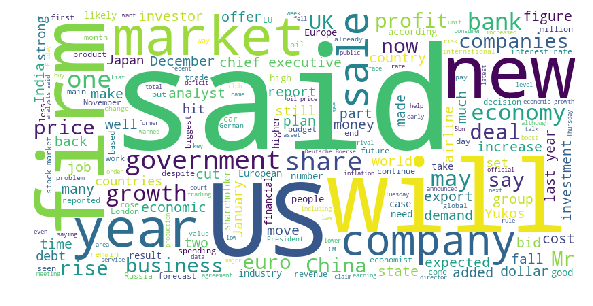

entertainment


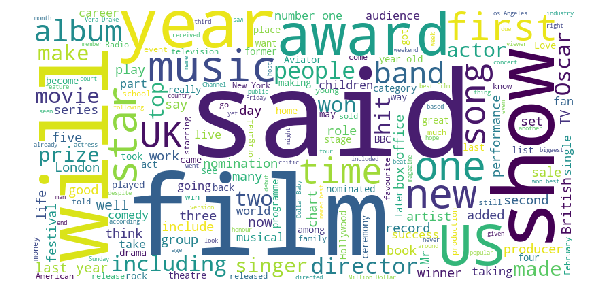

politics


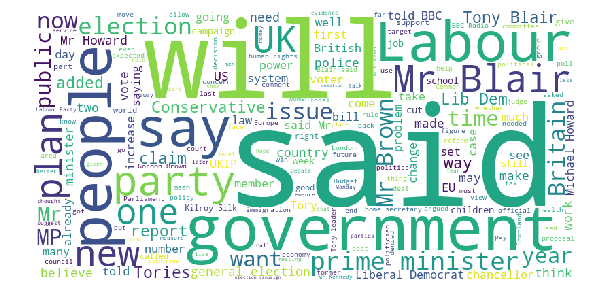

sport


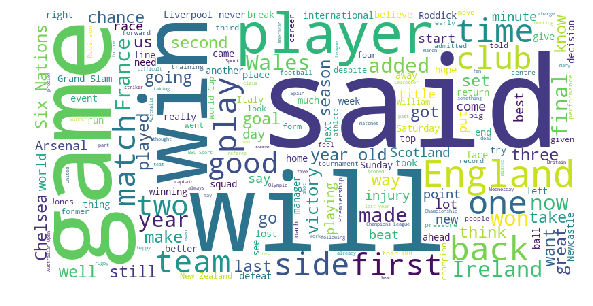

tech


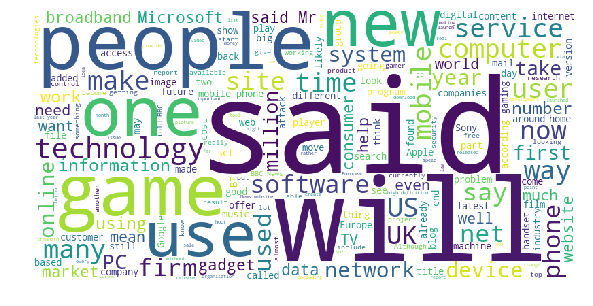

ALL Categories:


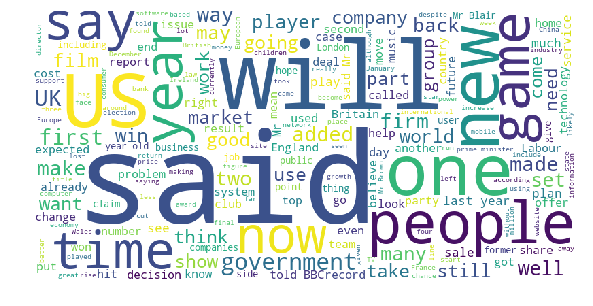

In [0]:

#WordCloud
cat = df['category'].unique()

for i in range(0,len(cat)):
    words = ' '.join(df.loc[df['category']==cat[i], 'text'])

    wordcloud = WordCloud( 
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=800,
                          height=400
                ).generate(words)
    print(cat[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

words = ' '.join(df.loc[:, 'text'])

wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(words)
print("ALL Categories:")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Label Encoder
#### Use inverse_transform at the end after predicting

In [0]:
#Split training and test set using stratified sampling and test size of 20%
y = df['category']
X = df.drop(['category','id'],axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X,y,stratify=y, test_size=0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('before: %s ...' %y_train[:5])

#Transform label names to unique number using label encoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 1508       sport
1908        tech
2104        tech
2019        tech
1245    politics
Name: category, dtype: object ...
after: [3 4 4 ... 1 0 2] ...


In [0]:
print(np.bincount(y_train))
print(y.value_counts())
print(le.inverse_transform([i for i in range(5)]))

[408 309 333 409 321]
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
['business' 'entertainment' 'politics' 'sport' 'tech']


## Preprocess Data - (split by \n, remove periods, remove slashes)

### HAN requires the data to be 3D instead of 2D like in CNN or RNN. i.e, we will generate data as list of sentences which are list of words

In [0]:
#Parameters for hyperparameter  tuning
dropout = 0.3
EMBEDDING_DIM = 300
traina = True #embeedding layer trainable

In [0]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [0]:
#Preprocess both train and test separately. Remove punctuations and other unwanted characters
def replace_punct(st,punct):
  for i in punct:
    if i=="..":
      st = st.replace("..",'.')
    elif i=="--" or i == '-':
      st = st.replace(i,' ')
    else:
      st = st.replace(i,'')
  return st
punct = word_tokenize(string.punctuation) + ['``','...','..','\'s','--','-','n\'t','\'','(',')','[',']','{','}']
texts = preprocess(X_train['text']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x,punct))
test_text = preprocess(X_test['text']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x,punct))

In [0]:
#Get all sentences for all news
articles = texts.map(lambda x: sent_tokenize(x))
test_articles = test_text.map(lambda x: sent_tokenize(x))

{'boxes': [<matplotlib.lines.Line2D at 0x7f94b6573ac8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f94b6df37f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f94b6df3d30>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f94b6df3828>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f94b6573cc0>,
  <matplotlib.lines.Line2D at 0x7f94b6df3400>]}

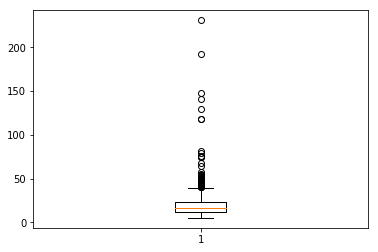

In [0]:
#Find the optimum sentence length and number of sentences for tokenization by generating a boxplot
# and choosing MAX_SENTS and MAX_SENT_LENGTH such that we remove outliers
max_se = []
max_se_length = []
for x in articles:
  max_se.append(len(x))
  for y in x:
    max_se_length.append(len(y.split()))
  
plt.boxplot(max_se,showcaps=True)
# We can see in below plot that optimal number of sentences is around 50

{'boxes': [<matplotlib.lines.Line2D at 0x7f94b6096908>],
 'caps': [<matplotlib.lines.Line2D at 0x7f94b6df5d30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f94b6df5128>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f94b6df5b70>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f94b60962b0>,
  <matplotlib.lines.Line2D at 0x7f94b6df55f8>]}

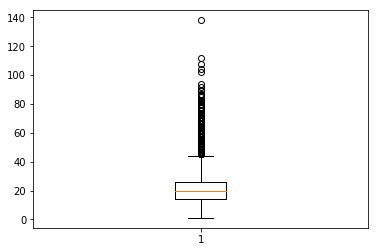

In [0]:
plt.boxplot(max_se_length,showcaps=True)
# We can see in below plot that optimal sentence length is around 50

In [0]:
#Choose parameters accordingly and load glove model corresponding to the embedding dimension that was the best in hyperparameter tuning
MAX_SEQUENCE_LENGTH = 1000
MAX_SENT_LENGTH = 50
MAX_SENTS = 50
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('glove.6B.'+str(EMBEDDING_DIM)+'d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
#Create 3D data with tokenizer word_index. Neglect words which are not in word_index
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(articles):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1
                    
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 28512 unique tokens.


In [0]:
#Do the same for test data with the same tokenizer (fit on train data). Neglect words which are not in word_index
test_data = np.zeros((len(test_text), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(test_articles):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and word in tokenizer.word_index and tokenizer.word_index[word]<MAX_NB_WORDS:
                    test_data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

In [0]:
test_data.shape

(445, 50, 50)

In [0]:
#Split training and validation data with 20% split. So final is training 64%, validation 16% and test 20% of whole data
labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

np.random.seed(123)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

Shape of data tensor: (1780, 50, 50)
Shape of label tensor: (1780, 5)


In [0]:
'''
#Stop Words and Lemmatization   
lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['.','``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
'''

"\n#Stop Words and Lemmatization   \nlemmatizer = WordNetLemmatizer()\nstopw = nltk.corpus.stopwords.words('english')\npunct = string.punctuation\npunct = word_tokenize(punct)\npunct += ['.','``','...',''s','--','-','n't',''']\nstopw += punct\ndef token_stop(text):\n    global stopw\n    global lemmatizer\n    words = word_tokenize(text)\n    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]\n    return filtered\n  \nX_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])\nX_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])\n"

In [0]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
#Map label name to its index
labels_index = {}
for i in range(5):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

## Train Model

In [0]:
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=traina)

In [0]:
#Callbacks - checkpointer, early stopping and tensorboard
model_name = "HAN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+str(traina)
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_han = TensorBoard(log_dir='./Graph_HAN', histogram_freq=1,write_graph=True,write_grads=True, write_images=True)

In [0]:
#Model Architecture
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_layer = Bidirectional(LSTM(100,dropout=dropout))(embedded_sequences)
sentEncoder = Model(sentence_input, lstm_layer)

article_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
article_encoder = TimeDistributed(sentEncoder)(article_input)
lstm_layer_sent = Bidirectional(LSTM(100,dropout=dropout))(article_encoder)
preds = Dense(len(labels_index), activation='softmax')(lstm_layer_sent)
han_model = Model(article_input, preds)

han_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
han_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 200)           8874700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 9,116,505
Trainable params: 9,116,505
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Train Model
stmillis = int(round(time.time() * 1000))
history = han_model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping,tensorboard_han])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Instructions for updating:
Use tf.cast instead.
Train on 1424 samples, validate on 356 samples
Epoch 1/50
1424/1424 [==============================] - 14s 10ms/step - loss: 1.2700 - acc: 0.5681 - val_loss: 0.4591 - val_acc: 0.9073

Epoch 00001: val_loss improved from inf to 0.45915, saving model to HAN-0.3-300-Trainable-True_weights.01-0.46.hdf5
Epoch 2/50
1424/1424 [==============================] - 10s 7ms/step - loss: 0.4879 - acc: 0.8567 - val_loss: 0.3568 - val_acc: 0.8933

Epoch 00002: val_loss improved from 0.45915 to 0.35682, saving model to HAN-0.3-300-Trainable-True_weights.02-0.36.hdf5
Epoch 3/50
1424/1424 [==============================] - 10s 7ms/step - loss: 0.2361 - acc: 0.9361 - val_loss: 0.4037 - val_acc: 0.8427

Epoch 00003: val_loss did not improve from 0.35682
Epoch 4/50
1424/1424 [==============================] - 10s 7ms/step - loss: 0.1527 - acc: 0.9529 - val_loss: 0.0867 - val_acc: 0.9747

Epoch 00004: val_loss improved from 0.35682 to 0.08670, saving model to H

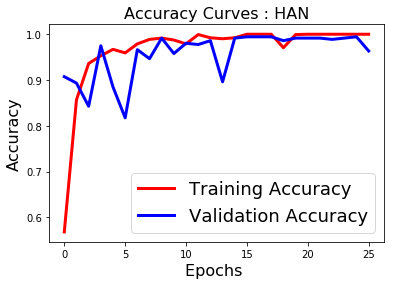

In [0]:
#Plot accuracy curve
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig.savefig(model_name+'-ACC'+'.png')
plt.show()

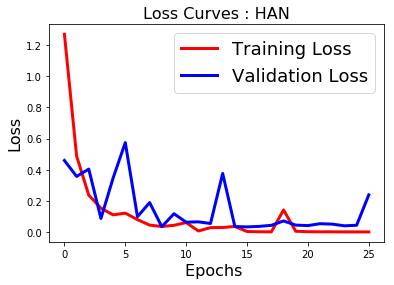

In [0]:
#Plot loss curve
fig=plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves : HAN',fontsize=16)
fig.savefig(model_name+'.png')
plt.show()

In [0]:
model_name

'HAN-0.3-300-Trainable-True'

In [0]:
# Save the trained weights
han_model.save(model_name + ".h5")

# Save model config as json
model_json = han_model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp HAN* gdrive/My\ Drive/

## Predict on Test Data

In [0]:
#Load the weights of the model which had the best validation loss
best_model_weights = 'HAN-0.3-300-Trainable-True_weights.16-0.03.hdf5'
!cp gdrive/My\ Drive/HAN-0.3-300-Trainable-True_weights.16-0.03.hdf5 .
!cp gdrive/My\ Drive/HAN-0.3-300-Trainable-True.json .

In [0]:
json_file = open('HAN-0.3-300-Trainable-True.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
best_model = model_from_json(loaded_model_json)

In [0]:
best_model.load_weights(best_model_weights)
best_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


In [0]:
def find_test_acc(prediction):
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")

In [0]:
def predict_test(model):
  prediction = model.predict(test_data)
  find_test_acc(prediction)

In [61]:
#Final test accuracy on the best model
predict_test(best_model)

Test Accuracy: 97.07865168539325 %


## Tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-02 23:32:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.206.36.121, 52.22.236.254, 34.206.130.40, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.206.36.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.30M  41.4MB/s    in 0.3s    

2019-05-02 23:32:30 (41.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './Graph_HAN'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://e8c26071.ngrok.io


In [0]:
!cp -r ./Graph_HAN gdrive/My\ Drive/.

In [0]:
!ls

accuracy_cnn.png	  HAN_weights.08-0.25.hdf5
bbc			  HAN_weights.08-1.18.hdf5
bbc-fulltext.zip	  HAN_weights.09-0.17.hdf5
gdrive			  HAN_weights.09-1.14.hdf5
glove.6B.100d.txt	  HAN_weights.11-0.16.hdf5
glove.6B.200d.txt	  HAN_weights.11-0.22.hdf5
glove.6B.300d.txt	  HAN_weights.11-1.12.hdf5
glove.6B.50d.txt	  HAN_weights.12-0.15.hdf5
glove.6B.zip		  HAN_weights.12-0.19.hdf5
HAN.h5			  HAN_weights.12-1.10.hdf5
HAN.json		  HAN_weights.13-0.13.hdf5
HAN_weights.01-0.82.hdf5  HAN_weights.13-0.15.hdf5
HAN_weights.01-0.92.hdf5  HAN_weights.14-0.12.hdf5
HAN_weights.01-0.95.hdf5  HAN_weights.14-0.13.hdf5
HAN_weights.01-1.61.hdf5  HAN_weights.16-0.13.hdf5
HAN_weights.02-0.45.hdf5  HAN_weights.16-1.02.hdf5
HAN_weights.02-0.47.hdf5  HAN_weights.19-0.92.hdf5
HAN_weights.02-0.58.hdf5  HAN_weights.23-0.12.hdf5
HAN_weights.02-1.59.hdf5  HAN_weights.23-0.91.hdf5
HAN_weights.03-0.53.hdf5  HAN_weights.24-0.10.hdf5
HAN_weights.04-0.32.hdf5  HAN_weights.25-0.10.hdf5
HAN_weights.04-0.44.hdf5  HAN_weights.30

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(best_model, to_file='han_model.png', show_shapes=True, show_layer_names=True)

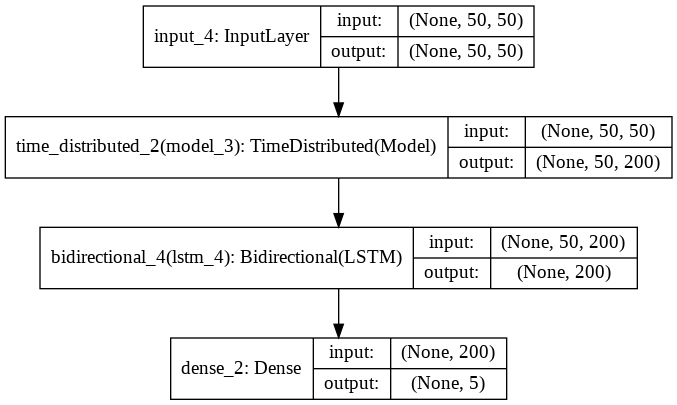

In [0]:
from PIL import Image
display(Image.open('han_model.png'))